# Kaggle Exercise -- House Prices Prediction

## Read Dataset

In [1]:
%matplotlib inline
import pandas as pd # handle csv dataset
import d2lzh as d2l
import numpy as np
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, data as gdata, nn

In [2]:
train_data = pd.read_csv('../../data/house_prices/train.csv') # read training data
test_data =  pd.read_csv('../../data/house_prices/test.csv') # read testing data

In [3]:
train_data.shape, test_data.shape 

((1460, 81), (1459, 80))

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]] 

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
# concat train data and test data into all features
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:-1]), sort=False) 
# the first feature id is meaningless for training.

## Proprecess Dataset

The first thing we need to do is `Standardization` of continuous features. Assume the mean of a feature in the dataset is $\mu$, and the standard deviation is $\sigma$. For each element $x$, we transform it $\frac{x-\mu}{\sigma}$ to standardize each feature. For absent featrue, we can make them mean $\mu$.

In [6]:
# handle continuous value 
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
            lambda x: (x - x.mean())/(x.std())) # standardize feature => (x - mean)/std
# after standardization, the mean of each feature is 0
all_features[numeric_features] = all_features[numeric_features].fillna(0) # make null zero

In [7]:
# handle discrete value 
all_features = pd.get_dummies(all_features, dummy_na=True)
# dummy_na => make null value valid and create them indicative feature
all_features.shape

(2919, 331)

In [8]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values) # get train features
test_features = nd.array(all_features[n_train:].values) # get test features
train_lables = nd.array(train_data.SalePrice.values).reshape((-1, 1)) # get lables

## Train Model

In [9]:
loss = gloss.L2Loss() # square loss function

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(256, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    return net

Use `Logarithm Root Mean Square` Error to evaluate model.
$$\sqrt{\frac1n\sum_{i=1}^n\left(\log(y^{(i)}) - \log(\hat y^{(i)})\right)^2}$$

In [10]:
def log_rms(net, features, labels):
    # make number which less than 1 as 1 to make log function more stable
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    # clip(x, x_min, x_max) make number smalled than x_min as x_min
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    # why we need to multiply 2? As Square Loss Function is 1/2(y_hat - h)^2. There are 1/2.
    return rmse.asscalar() # return a scalar.

Use `Adam Optimization Function` here.

In [11]:
def train(net, train_features, train_lables, test_features, test_labels, 
         num_epoch, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_lables),
                                 batch_size, shuffle=True)
    
    # use adam optimization function here instead of sgd optimizatin function
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epoch):
        for X, y in train_iter:
            with autograd.record(): # forward pass
                l = loss(net(X), y)
            l.backward() # backword pass
            trainer.step(batch_size) # optimize model
        train_ls.append(log_rms(net, train_features, train_lables))
        if test_labels is not None:
            test_ls.append(log_rms(net, test_features, test_labels))
        
    return train_ls, test_ls

## K-Fold Cross-Validation

In [12]:
def get_k_fold_data(k, i, X, y): # k-th fold 
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k): 
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # slice[start, stop[, step]]
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else: # concat training data
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
            
    return X_train, y_train, X_valid, y_valid

In [13]:
def k_fold(k, X_train, y_train, num_epochs,
          learning_rate, weight_delay, batch_size):
    train_l_sum, valid_l_sum = 0, 0 # after k-th fold validation, the sum of loss
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # data is X_train, y_train, X_valid, y_valid
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, #*data is to unpack
                                  weight_delay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epoch', 'rmse',
                        range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'%
              (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k # average loss

## Select Model

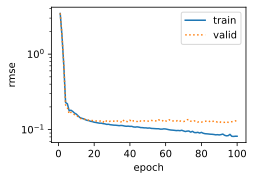

fold 0, train rmse 0.081640, valid rmse 0.131647
fold 1, train rmse 0.074205, valid rmse 0.143725
fold 2, train rmse 0.064497, valid rmse 0.139100
fold 3, train rmse 0.061949, valid rmse 0.114088
fold 4, train rmse 0.073467, valid rmse 0.150799
5-fold validation: avg train rmse 0.071151, avg valid rmse 0.135872


In [14]:
k, num_epochs, lr, weight_delay, batch_size = 5, 100, 0.05, 5, 64
train_l, valid_l = k_fold(k, train_features, train_lables, num_epochs, lr,
                         weight_delay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f'
     %(k, train_l, valid_l))

## Predict and Submit Result in Kaggle

In [91]:
def train_and_pred(train_features, test_features, train_lables, test_data,
                  num_epochs, lr, weight_delay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_lables, None, None,
                       num_epochs, lr, weight_delay, batch_size)
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    subbmision = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1) # hstack
    subbmision.to_csv('subbmision.csv', index=False)

In [ ]:
train_and_pred(train_features, test_features, train_lables, test_data,
              num_epochs, lr, weight_delay, batch_size)